In [1]:
import tensorflow as tf
import os
import sys
add_dir = os.path.abspath('./data/')
sys.path.append(add_dir)
import tf_extended as tfe
import numpy as np
import cv2
import tensorflow.contrib.slim as slim
from tensorflow.python.ops import random_ops,control_flow_ops
from tensorflow.python.keras.initializers import he_normal
import math
import random
from data import ssd_common
from data import loss_function
from matplotlib import pyplot as plt
from data import custom_layers
from data import np_methods
from ssd_network import *
from set_flags_variables import *
from ssd import *
from util import *
import pandas as pd
from ResneXt_modify import *

In [2]:
# some constant values
feat_layers=['block4', 'block7', 'block8', 'block9', 'block10', 'block11']
feat_shapes=[(38, 38), (19, 19), (10, 10), (5, 5), (3, 3), (1, 1)]
anchor_size_bounds=[0.15, 0.90]
anchor_sizes=[(21., 45.),
                      (45., 99.),
                      (99., 153.),
                      (153., 207.),
                      (207., 261.),
                      (261., 315.)]
anchor_ratios=[[2, .5],
                       [2, .5, 3, 1./3],
                       [2, .5, 3, 1./3],
                       [2, .5, 3, 1./3],
                       [2, .5],
                       [2, .5]]
anchor_steps=[8, 16, 32, 64, 100, 300]
anchor_offset=0.5
normalizations=[20, -1, -1, -1, -1, -1]
prior_scaling=[0.1, 0.1, 0.2, 0.2]


In [3]:
#####################the start of bottle neck##################
inputs = tf.placeholder(tf.float32, [None, FLAGS.image_size, FLAGS.image_size, 3])
# keep_prob = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool)
#####resnext######################
# resnext = ResNeXt(inputs,is_training)
# end_points = resnext.model
#################################
####vgg16 backbone##
end_points = vgg16_backbone(inputs,is_training)
####################################
predictions =[]
logits = []
localisations=[]
for i,layer in enumerate(feat_layers):
    with tf.variable_scope(layer + '_box'):
        p, l = ssd_multibox_layer(end_points[layer],anchor_sizes[i],anchor_ratios[i],feat_shapes[i],normalizations[i])
#         predictions.append(tf.contrib.slim.softmax(p))
        predictions.append(tf.nn.sigmoid(p))
        logits.append(p)########(layers,batch_size,featuremap,featuremap,boxes_layer,num_class)
        localisations.append(l)#####(layers,batch_size,featuremap,featuremap,boxes_layer,4)


Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.


In [4]:
# generate bboxes for each feet layer
anchor_layers_original = ssd_anchors_all_layers((FLAGS.image_size,FLAGS.image_size),
                           feat_shapes,
                           anchor_sizes,
                           anchor_ratios,
                           anchor_steps,
                           offset=0.5,
                           dtype=np.float32)

In [5]:
decoded_boxes = ssd_common.tf_ssd_bboxes_decode(localisations,
                         anchor_layers_original,
                         prior_scaling=[0.1, 0.1, 0.2, 0.2],
                         scope='ssd_bboxes_decode')


In [6]:
def reshape_tensors(localisations_layer,logits_layer,predictions_layer):
    localisations_layer = tf.reshape(localisations_layer,(1,-1,4))
    logits_layer = tf.reshape(logits_layer,(1,-1,21))
    predictions_layer = tf.reshape(predictions_layer,(1,-1,21))
    return localisations_layer,logits_layer,predictions_layer

In [7]:
reshaped_locals = []
reshaped_logits = []
reshaped_predictions = []
for i in range(len(feat_layers)):
    temp_locals,temp_logits,temp_predictions = reshape_tensors(decoded_boxes[i],logits[i],predictions[i])
    reshaped_locals.append(temp_locals)
    reshaped_logits.append(temp_logits)
    reshaped_predictions.append(temp_predictions)
reshaped_locals = tf.concat(reshaped_locals,axis=1)
reshaped_logits = tf.concat(reshaped_logits,axis=1)
reshaped_predictions = tf.concat(reshaped_predictions,axis=1)

classes = tf.argmax(reshaped_predictions,axis=2)
scores = tf.reduce_max(reshaped_predictions,axis=2)
#remove boxes belongs to background
scores = scores * tf.cast(classes >0, scores.dtype)
#remove boxes with low scores
mask = tf.greater(scores, score_threshold)
classes = classes * tf.cast(mask, classes.dtype)
scores = scores * tf.cast(mask, scores.dtype)
ymin = tf.zeros_like(reshaped_locals[...,0])
xmin = tf.zeros_like(reshaped_locals[...,1])
ymax = tf.ones_like(reshaped_locals[...,2])
xmax = tf.ones_like(reshaped_locals[...,3])

ymin = tf.maximum(reshaped_locals[...,0],ymin)
xmin = tf.maximum(reshaped_locals[...,1],xmin)
ymax = tf.minimum(reshaped_locals[...,2],ymax)
xmax = tf.minimum(reshaped_locals[...,3],xmax)
boxes = tf.stack([ymin,xmin,ymax,xmax],axis = -1)

In [8]:
#start to remove boxes
mask_score = tf.greater_equal(scores,score_threshold)
mask_class = tf.not_equal(classes, 0)
total_mask = tf.logical_and(mask_score,mask_class)
total_index = tf.where(total_mask[0])
#remove background and scores>0.5
scores = tf.gather(scores,total_index[:,0],axis=1)
classes = tf.gather(classes,total_index[:,0],axis=1)
boxes = tf.gather(boxes,total_index[:,0],axis=1)
nms_index = tf.image.non_max_suppression(boxes[0], scores[0],200, iou_threshold=0.5)
#remove nms boxes
scores = tf.gather(scores[0],nms_index)
classes = tf.gather(classes[0],nms_index)
boxes = tf.gather(boxes[0],nms_index)

In [9]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

ckpt = tf.train.latest_checkpoint(FLAGS.checkpoint_dir)
if ckpt:
    saver.restore(sess,ckpt)
    print('restore from the checkpoint {0}'.format(ckpt))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /media/xinje/New Volume/ssd/vgg16/hnm/OCR--681500
restore from the checkpoint /media/xinje/New Volume/ssd/vgg16/hnm/OCR--681500


In [10]:
corresponding_dict = {1:'aeroplane',2:'bicycle',3:'bird',4:'boat',5:'bottle',6:'bus',7:'car',\
                      8:'chair',9:'cow',20:'diningtable',10:'dog',11:'horse',12:'motorbike',\
                     13:'pottedplant',14:'sheep',15:'sofa',16:'train',17:'tvmonitor',18:'cat',19:'person'}

In [11]:
# image_list = ['/media/xinje/New Volume/VOC07&12/VOC2007/test/JPEGImages/'+i for i in os.listdir('/media/xinje/New Volume/VOC07&12/VOC2007/test/JPEGImages')]


In [12]:
# for temp_img in image_list:
#     temp_image = read_one_img(temp_img,(300,300))
#     image = np.expand_dims(temp_image,axis=0)
#     [true_boxes,true_classes,true_scores,true_index]  = sess.run([boxes,classes,scores,nms_index],feed_dict={inputs:image,is_training: False})
#     # [true_boxes,true_classes,true_scores] = sess.run([boxes,classes,scores],feed_dict={inputs:image,is_training: False,keep_prob:1.0})

#     a = (true_boxes*300)
# #     temp_image = cv2.imread(temp_img)
# #     temp_image = temp_image[:,:,::-1]
# #     temp_image = cv2.resize(temp_image,(300,300))
#     plt.figure(figsize=(10,10))
#     plt.hlines(a[...,0],a[...,1],a[...,3],colors='red')
#     plt.hlines(a[...,2],a[...,1],a[...,3],colors='red')
#     plt.vlines(a[...,1],a[...,0],a[...,2],colors='red')
#     plt.vlines(a[...,3],a[...,0],a[...,2],colors='red')
#     for i in range(len(true_classes)):
#         position = ((a[i][3]+a[i][1])/2,(a[i][2]+a[i][0])/2)
#         plt.text(position[0],position[1],corresponding_dict[true_classes[i]],color='g',size = 20)
#     plt.imshow(temp_image)
#     plt.show()

In [13]:
# for single_img in os.listdir('./VOC2007/train/JPEGImages/'):
#     image_path = './VOC2007/train/JPEGImages/'+single_img
#     print(single_img)
#     print(image_path)
#     image = cv2.imread(image_path)
#     image = image[:,:,::-1]/255
#     image = cv2.resize(image,(300,300))
#     image = np.expand_dims(image,axis=0)
#     [true_boxes,true_classes,true_scores] = sess.run([boxes,classes,scores],feed_dict={inputs:image,is_training: False})

#     index = (true_scores>0.5)
#     index_pos = (true_classes!=0)
#     index = np.logical_and(index,index_pos)
#     final_boxes = true_boxes[index]
#     final_classes = true_classes[index]
#     final_scores = true_scores[index]
#     ### nms
#     rclasses,rscores,rboxes = np_methods.bboxes_nms(final_classes, final_scores, final_boxes, nms_threshold=0.5)

#     a = (rboxes*300)
#     temp_image = cv2.imread(image_path)
#     temp_image = temp_image[:,:,::-1]
#     temp_image = cv2.resize(temp_image,(300,300))
#     plt.figure(figsize=(10,10))
#     plt.hlines(a[...,0],a[...,1],a[...,3],colors='red')
#     plt.hlines(a[...,2],a[...,1],a[...,3],colors='red')
#     plt.vlines(a[...,1],a[...,0],a[...,2],colors='red')
#     plt.vlines(a[...,3],a[...,0],a[...,2],colors='red')
#     for i in range(len(rclasses)):
#         position = ((a[i][3]+a[i][1])/2,(a[i][2]+a[i][0])/2)
#         plt.text(position[0],position[1],corresponding_dict[rclasses[i]],color='g',size = 20)
#     plt.imshow(temp_image)
#     plt.show()

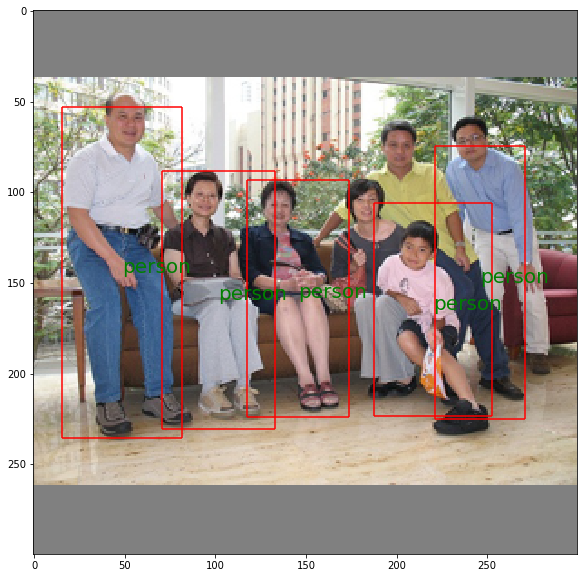

In [14]:
#calculate MAP
annotation = get_path_and_annotation('/media/xinje/New Volume/VOC07&12/VOC2007/test/test_OCR.txt')
# for temp_annotation in annotation:
image_data, box_data,cls_data = get_random_data(annotation[5], (300,300), random=False, max_boxes=20, jitter=.3, hue=.1, sat=1.5, val=1.5, proc_img=True,crop=False)
mask_index = (cls_data!=0)
cls_data = cls_data[mask_index]
box_data = box_data[mask_index]/300

image = np.expand_dims(image_data,axis=0)
[pred_boxes,pred_classes,pred_scores,true_index]  = sess.run([boxes,classes,scores,nms_index],feed_dict={inputs:image,is_training: False})
#####pred_boxes: ymin ,xmin,ymax,xmax
a = (pred_boxes*300)
plt.figure(figsize=(10,10))
plt.hlines(a[...,0],a[...,1],a[...,3],colors='red')
plt.hlines(a[...,2],a[...,1],a[...,3],colors='red')
plt.vlines(a[...,1],a[...,0],a[...,2],colors='red')
plt.vlines(a[...,3],a[...,0],a[...,2],colors='red')
for i in range(len(pred_classes)):
    position = ((a[i][3]+a[i][1])/2,(a[i][2]+a[i][0])/2)
    plt.text(position[0],position[1],corresponding_dict[pred_classes[i]],color='g',size = 20)
plt.imshow(image_data)
plt.show()

In [15]:
def voc_ap(rec, prec, use_07_metric=False):
    """Compute VOC AP given precision and recall. If use_07_metric is true, uses
    the VOC 07 11-point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def voc_eval(gt_dict, val_preds, classidx, iou_thres=0.5, use_07_metric=False):
    '''
    Top level function that does the PASCAL VOC evaluation.
    '''
    # 1.obtain gt: extract all gt objects for this class
    class_recs = {}
    npos = 0
    for img_id in gt_dict:
        R = [obj for obj in gt_dict[img_id] if obj[-1] == classidx]
        bbox = np.array([x[:4] for x in R])
        det = [False] * len(R)
        npos += len(R)
        class_recs[img_id] = {'bbox': bbox, 'det': det}
    # 2. obtain pred results
    pred = [x for x in val_preds if x[-1] == classidx]
    img_ids = [x[0] for x in pred]
    confidence = np.array([x[-2] for x in pred])
    BB = np.array([[x[1], x[2], x[3], x[4]] for x in pred])

    # 3. sort by confidence
    sorted_ind = np.argsort(-confidence)
    try:
        BB = BB[sorted_ind, :]
#         print(BB)
    except:
        print('no box, ignore')
        return 0
#         return 1e-6, 1e-6, 0, 0, 0
    img_ids = [img_ids[x] for x in sorted_ind]

    # 4. mark TPs and FPs
    nd = len(img_ids)
    tp = np.zeros(nd)
    fp = np.zeros(nd)

    for d in range(nd):
        # all the gt info in some image
        R = class_recs[img_ids[d]]
        bb = BB[d, :]
        ovmax = -np.Inf
        BBGT = R['bbox']

        if BBGT.size > 0:
            # calc iou
            # intersection
            iymin = np.maximum(BBGT[:, 0], bb[0])
            ixmin = np.maximum(BBGT[:, 1], bb[1])
            iymax = np.minimum(BBGT[:, 2], bb[2])
            ixmax = np.minimum(BBGT[:, 3], bb[3])
            iw = np.maximum(ixmax - ixmin , 0.)
            ih = np.maximum(iymax - iymin , 0.)
            inters = iw * ih

            # union
            uni = ((bb[2] - bb[0]) * (bb[3] - bb[1]) + (BBGT[:, 2] - BBGT[:, 0]) * (
                        BBGT[:, 3] - BBGT[:, 1]) - inters)
            overlaps = inters / (uni+1e-8)
            ovmax = np.max(overlaps)
            jmax = np.argmax(overlaps)

        if ovmax > iou_thres:
            # gt not matched yet
            if not R['det'][jmax]:
                tp[d] = 1.
                R['det'][jmax] = 1
            else:
                fp[d] = 1.
        else:
            fp[d] = 1.

    # compute precision recall
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos)
    # avoid divide by zero in case the first detection matches a difficult
    # ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)
    return ap
    # return rec, prec, ap
#     return npos, nd, tp[-1] / float(npos), tp[-1] / float(nd), ap

In [16]:
gt_dict = {}
pred_content = []
annotation = get_path_and_annotation('/media/xinje/New Volume/VOC07&12/VOC2007/test/test_OCR.txt')
for i in range(len(annotation)):
    image_path,image_data,gt_data = get_gt_data(annotation[i], (300,300), random=False, max_boxes=20, jitter=.3, hue=.1, sat=1.5, val=1.5, proc_img=True)
#     box_data = gt_data[:,0:4]
#     cls_data = gt_data[:,4]
    gt_data = gt_data[gt_data[:,4]!=0]
    gt_dict[image_path] = gt_data
    image = np.expand_dims(image_data,axis=0)
    [pred_boxes,pred_classes,pred_scores]  = sess.run([boxes,classes,scores],feed_dict={inputs:image,is_training: False})
    ##combine image_path, boxes,classes,scores
    for j in range(pred_classes.shape[0]):
        y_min, x_min, y_max, x_max = pred_boxes[j]
        score = pred_scores[j]
        label = pred_classes[j]
        pred_content.append([image_path, y_min, x_min, y_max, x_max, score, label])
#     ap_one_img = []
#     for j in range(1,21):
#         ap = voc_eval(gt_dict, pred_content, j, iou_thres=0.5, use_07_metric=True)
#         ap_one_img.append(ap)
#     ap_list.append(ap_one_img)

In [17]:
ap_list = []
for j in range(1,21):
    ap = voc_eval(gt_dict, pred_content, j, iou_thres=0.5, use_07_metric=True)
    ap_list.append(ap)
np.array(ap_list).mean()

0.33813243238349106

In [18]:
ap_list

[0.3573164803111327,
 0.5378851594158575,
 0.24941029120133595,
 0.16827852998065765,
 0.15881708652792992,
 0.35809312638580926,
 0.4460918799725692,
 0.17506142506142508,
 0.325036075036075,
 0.3408730158730159,
 0.5392934390771449,
 0.4441176570276179,
 0.1575757575757576,
 0.25222816399286985,
 0.2355769230769231,
 0.43574214862874655,
 0.4381976883459097,
 0.4361105813836386,
 0.4398977642499504,
 0.26704545454545453]

In [19]:
annotation = get_path_and_annotation('/media/xinje/New Volume/VOC07&12/VOC2007/train/train_OCR.txt')
image_data, box_data,cls_data = get_random_data(annotation[0], (300,300), random=True, max_boxes=30, jitter=.3, hue=.1, sat=1.5, val=1.5, proc_img=True,crop=True)

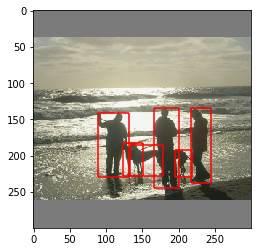

In [20]:
plt.imshow(image_data)
plt.vlines(box_data[:,1],box_data[:,0],box_data[:,2],'r')
plt.vlines(box_data[:,3],box_data[:,0],box_data[:,2],'r')
plt.hlines(box_data[:,0],box_data[:,1],box_data[:,3],'r')
plt.hlines(box_data[:,2],box_data[:,1],box_data[:,3],'r')

In [21]:
bboxes ,temp = random_crop_with_constraints(box_data, (300,300), min_scale=0.3, max_scale=1,
                                 max_aspect_ratio=2, constraints=None,
                                 max_trial=50)

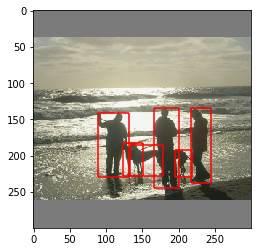

In [22]:
plt.imshow(image_data[temp[0]:(temp[0]+temp[2]),temp[1]:(temp[1]+temp[3])])
plt.vlines(bboxes[:,1],bboxes[:,0],bboxes[:,2],'r')
plt.vlines(bboxes[:,3],bboxes[:,0],bboxes[:,2],'r')
plt.hlines(bboxes[:,0],bboxes[:,1],bboxes[:,3],'r')
plt.hlines(bboxes[:,2],bboxes[:,1],bboxes[:,3],'r')

In [23]:
annotation = get_path_and_annotation('/media/xinje/New Volume/VOC07&12/VOC2007/train/train_OCR.txt')
train_iter = read_data(annotation,FLAGS.batch_size,is_random=True)

In [24]:
image_batch,annotation_batch,cls_batch = next(train_iter)

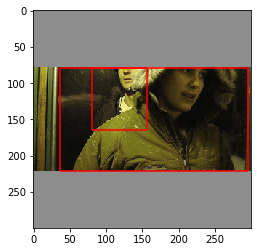

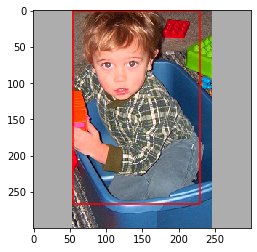

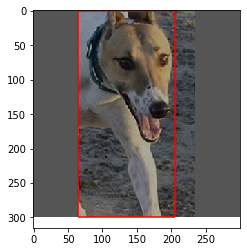

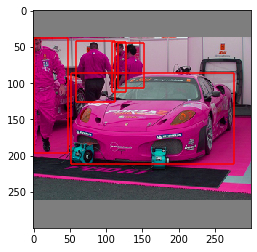

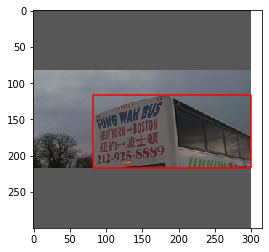

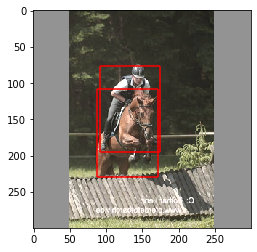

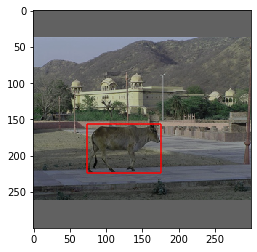

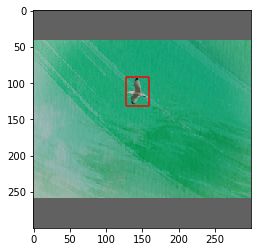

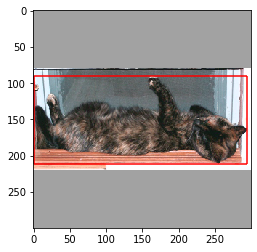

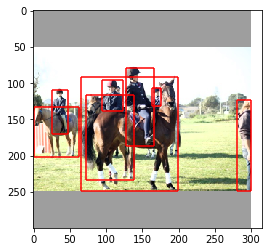

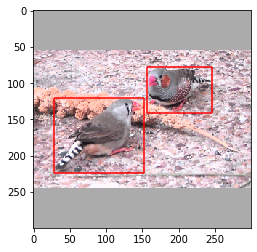

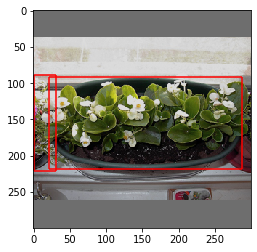

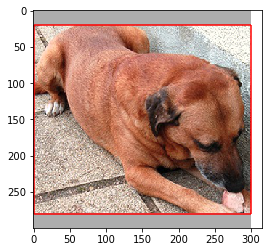

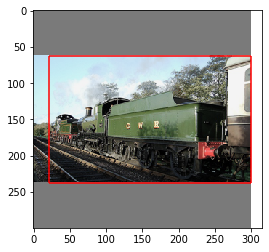

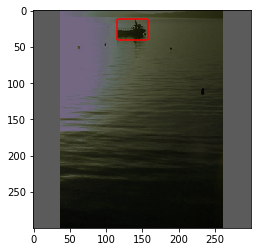

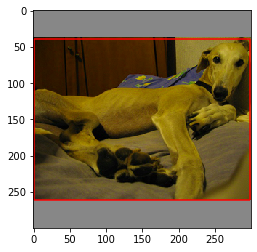

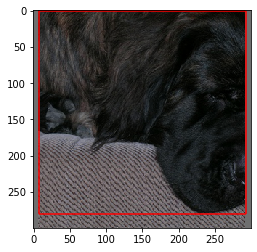

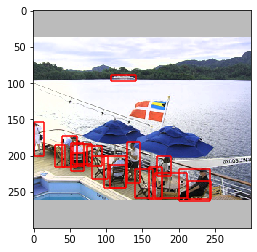

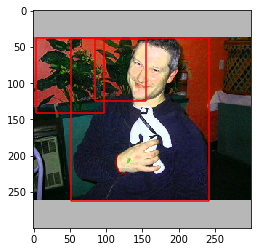

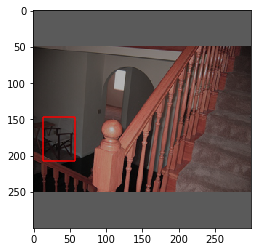

In [25]:
for i in range(FLAGS.batch_size):
    image_data = image_batch[i]
    bboxes = annotation_batch[i]*300
    plt.imshow(image_data)
    plt.vlines(bboxes[:,1],bboxes[:,0],bboxes[:,2],'r')
    plt.vlines(bboxes[:,3],bboxes[:,0],bboxes[:,2],'r')
    plt.hlines(bboxes[:,0],bboxes[:,1],bboxes[:,3],'r')
    plt.hlines(bboxes[:,2],bboxes[:,1],bboxes[:,3],'r')
    plt.show()
    